In [9]:
from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt

import numpy as np
import torch
import warnings

from droplet_approximation import *

In [10]:
# Do NOT edit this cell. Instead, make any changes you want in the cell below it by setting
# these variables.

# This model corresponds to "Model Box Uncoupled 400M l1 Residual 14 Epochs" in the group drive
model_load_paths = ["../models/network_box_uncoupled_400M_l1_residual_epoch_14.pth"]
model_names      = [ path.split( "/" )[-1].split( "." )[0].replace( "_", " " ) for path in model_load_paths ]

# This gets passed to `set_parameter_ranges` in the notebook and in
# the analysis processes.
parameter_ranges = None

# Commit for each model
commit_SHAs = ["369bacc0ba5c7367f17ec71707a1df64afd1b6f5"]

In [11]:
# Edit settings here:

# These ranges correspond to "Model Box Uncoupled 400M l1 Residual 14 Epochs" in the group drive
parameter_ranges = {
    "radius": ( -6.75, -3.00 ),
    "relative_humidity": ( 0.98, 1.11 )
}

In [12]:
# This is to make it work with the current model. Remove if using a new model
set_parameter_ranges( parameter_ranges )

In [13]:
model_count = len( model_load_paths )

model_list  = [ ResidualNet() for i in range( model_count ) ]

for i in range( model_count ):
    model_list[i].load_state_dict( torch.load( model_load_paths[i] ) )

In [14]:
time_point_count      = 300
droplet_radius_range  = (-6.75, -3.0)

In [ ]:
# Generate data

droplet_count      = 30
results            = np.empty( (droplet_count, time_point_count, 2 ) )
radii              = 10 ** np.linspace( droplet_radius_range[0], droplet_radius_range[1], time_point_count )
droplet_parameters = np.empty( (droplet_count, time_point_count, 7) )

for i in range(droplet_count):
    #background_parameters = np.array( [ 290.0, 10**-17.66, 290.0, 1.04, 1.00, 0.1 ] )
    background_parameters  = np.hstack( [ scale_droplet_parameters( np.random.uniform( -1, 1, 6) )[1:], [0.1] ] )
    # Sample temperature
    background_parameters[0] = background_parameters[2] + np.random.uniform( -1.5, 1.5 )

    droplet_parameters[i]  = np.hstack( [ radii.reshape((-1, 1)), np.tile( background_parameters, (time_point_count, 1) ) ] )

In [ ]:
strict_tolerances = True

for i in range(droplet_count):
    print(f"On Particle {i}")
    for count in range( time_point_count ):
        with warnings.catch_warnings():
            # This will force an exception anytime
            # BDF does something weird
            warnings.simplefilter("error")
            try:
                if strict_tolerances:
                    results[i, count, :] = solve_ivp_float32_outputs( dydt, [0, 1], droplet_parameters[i, count, :2], atol=1.0e-8, rtol=0.0000001, method="BDF", t_eval=[droplet_parameters[i, count, -1]], args=(droplet_parameters[i, count, 2:-1],) ).y[:, 0]
                else:
                    results[i, count, :] = solve_ivp_float32_outputs( dydt, [0, 1], droplet_parameters[i, count, :2], method="BDF", t_eval=[droplet_parameters[i, count, -1]], args=(droplet_parameters[i, count, 2:-1],) ).y[:, 0]
            except:
                # If BDF failes, default to no change
                results[i,count,:] = droplet_parameters[i, count, :2]
                print(results[i,count,:])
                continue
#24.9 for normal
#87.4s for strict tolerances

On Particle 0
On Particle 1
On Particle 2
On Particle 3
On Particle 4
On Particle 5
On Particle 6
On Particle 7
On Particle 8
On Particle 9
On Particle 10
On Particle 11
On Particle 12
On Particle 13
On Particle 14
On Particle 15
On Particle 16
On Particle 17
On Particle 18
On Particle 19
On Particle 20
On Particle 21
On Particle 22
On Particle 23
On Particle 24
On Particle 25
On Particle 26
On Particle 27
On Particle 28
On Particle 29


In [51]:
# Null diff is the residual on radius/temperature
null_diff = results - droplet_parameters[:, :, :2]
null_log_diff = np.log10(results) - np.log10( droplet_parameters[:,:,:2])

In [52]:

mlp_results = np.empty_like( results )
for i in range(droplet_count):
    mlp_results[i] = do_inference( droplet_parameters[i, :, :-1], droplet_parameters[i,:, -1], model_list[0], "cpu")

mlp_diff = mlp_results - droplet_parameters[:, :, :2]
mlp_log_diff = np.log10( mlp_results ) - np.log10( droplet_parameters[:, :, :2] )

mlp_error = null_diff - mlp_diff
mlp_error[null_diff == 0.0] = 0.0

mlp_log_error = null_log_diff - mlp_log_diff
mlp_log_error[null_log_diff == 0.0] = 0.0

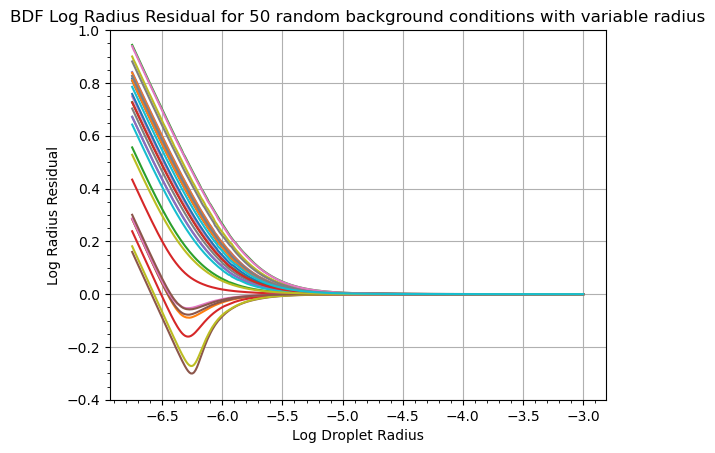

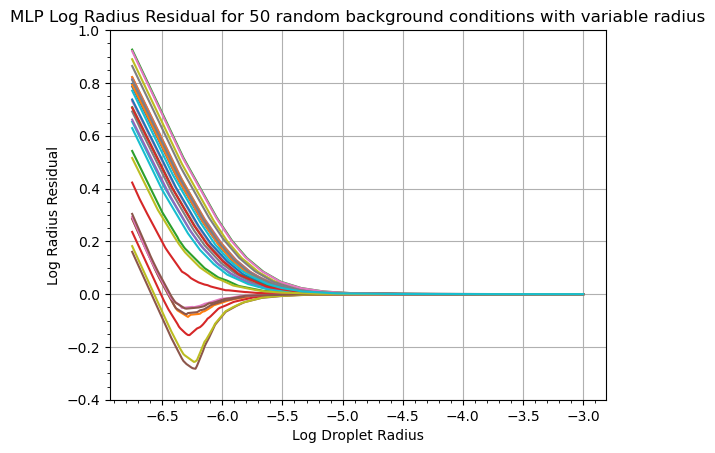

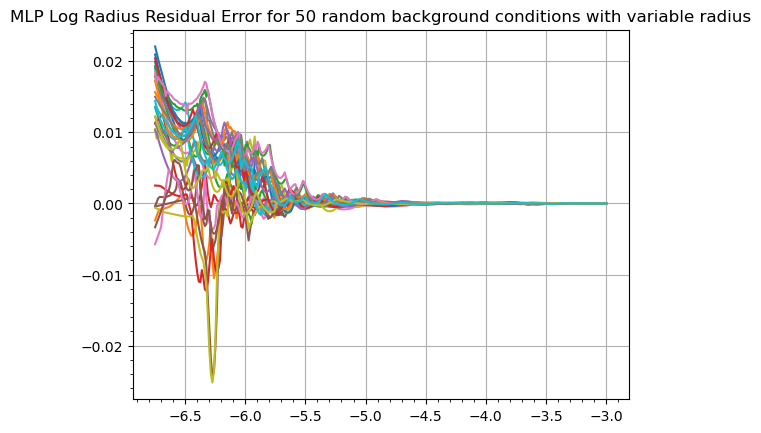

In [53]:
plt.figure()
plt.minorticks_on()
plt.grid()
plt.title("BDF Log Radius Residual for 50 random background conditions with variable radius")
plt.xlabel("Log Droplet Radius")
plt.ylabel("Log Radius Residual")
plt.ylim((-0.4, 1.0))
for i in range(droplet_count):
    plt.plot(np.log10(radii), null_log_diff[i, :, 0])
plt.show()


plt.figure()
plt.minorticks_on()
plt.grid()
plt.title("MLP Log Radius Residual for 50 random background conditions with variable radius")
plt.xlabel("Log Droplet Radius")
plt.ylabel("Log Radius Residual")
plt.ylim((-0.4, 1.0))
for i in range(droplet_count):
    plt.plot(np.log10(radii), mlp_log_diff[i, :, 0])
plt.show()

plt.figure()
plt.minorticks_on()
plt.grid()
plt.title("MLP Log Radius Residual Error for 50 random background conditions with variable radius")
for i in range(droplet_count):
    plt.plot(np.log10(radii), mlp_log_error[i, :, 0] )
plt.show()

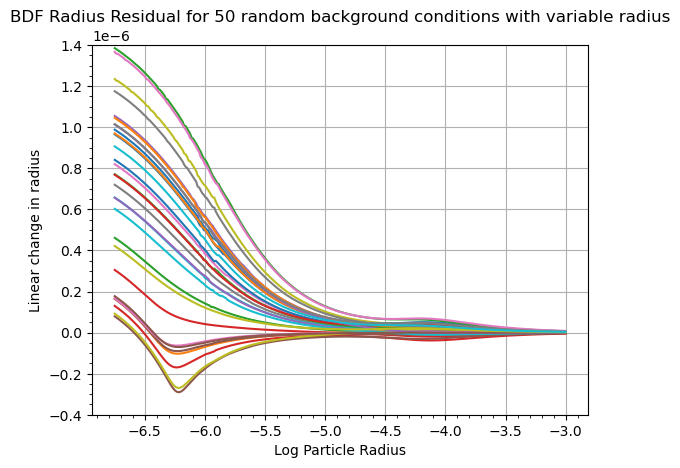

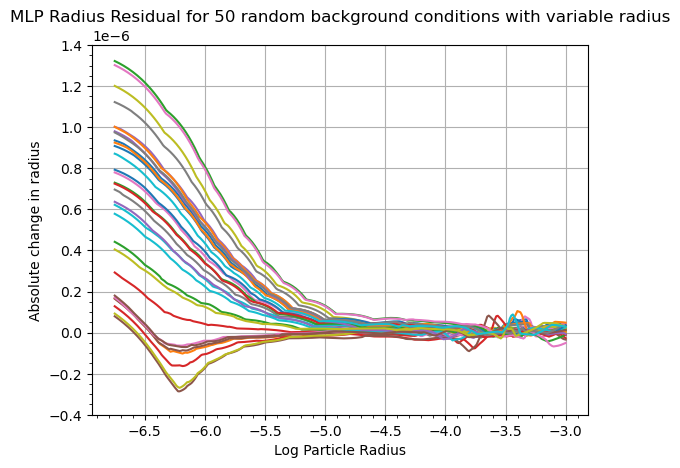

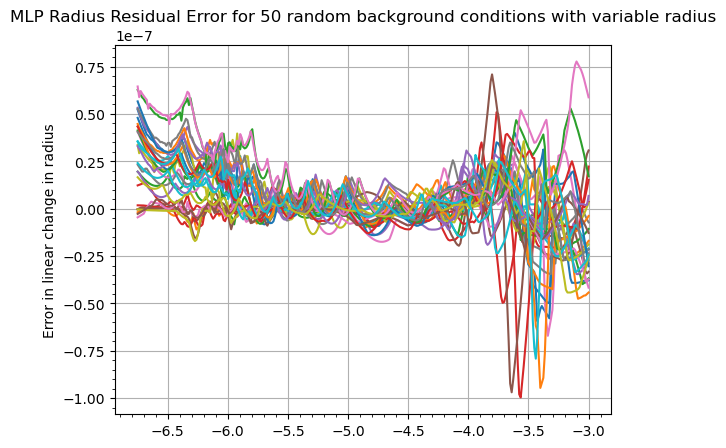

In [54]:

plt.figure()
plt.minorticks_on()
plt.grid()
plt.title(f"BDF Radius Residual for 50 random background conditions with variable radius")
plt.ylabel("Linear change in radius")
plt.xlabel("Log Particle Radius")
plt.ylim((-0.4e-6, 1.4e-6))
for i in range(droplet_count):
    plt.plot(np.log10(radii), null_diff[i, :, 0])
plt.show()


plt.figure()
plt.minorticks_on()
plt.grid()
plt.title(f"MLP Radius Residual for 50 random background conditions with variable radius")
plt.ylabel("Absolute change in radius")
plt.xlabel("Log Particle Radius")
plt.ylim((-0.4e-6, 1.4e-6))
for i in range(droplet_count):
    plt.plot(np.log10(radii), mlp_diff[i, :, 0])
plt.show()

plt.figure()
plt.minorticks_on()
plt.grid()
plt.title(f"MLP Radius Residual Error for 50 random background conditions with variable radius")
plt.ylabel("Error in linear change in radius")
for i in range(droplet_count):
    plt.plot(np.log10(radii), mlp_error[i, :, 0])
plt.show()


In [55]:
ratios     = np.empty( droplet_count )
log_ratios = np.empty( droplet_count )

for i in range(droplet_count):
    print( f"Ratio between radius residual for smallest/largest radius: {null_diff[i, 0, 0] / null_diff[i, -1, 0]}" )
    print( f"Ratio between log radius residual for smallest/largest radius: {null_log_diff[i, 0, 0] / null_log_diff[i, -1, 0]}" )

    ratios[i]     = null_diff[i, 0, 0] / null_diff[i, -1, 0]
    log_ratios[i] = null_log_diff[i, 0, 0] / null_log_diff[i, -1, 0]

    print("\n")

print( f"Average ratio for the residuals of the radius: {np.mean( ratios )}" )
print( f"Average ratio for residuals of the log radius: {np.mean( log_ratios )}" )

print( f"Median ratio for the residuals of the radius: {np.median( ratios )}" )
print( f"Median ratio for residuals of the log radius: {np.median( log_ratios )}" )


Ratio between radius residual for smallest/largest radius: 298.8169145051557
Ratio between log radius residual for smallest/largest radius: 568640.6978321918


Ratio between radius residual for smallest/largest radius: 53.54740872912018
Ratio between log radius residual for smallest/largest radius: 213156.41508183075


Ratio between radius residual for smallest/largest radius: -601.4350800555956
Ratio between log radius residual for smallest/largest radius: -1667524.1390612263


Ratio between radius residual for smallest/largest radius: -121.3121056554436
Ratio between log radius residual for smallest/largest radius: -397315.44179570203


Ratio between radius residual for smallest/largest radius: 870.8305518761766
Ratio between log radius residual for smallest/largest radius: 1598122.4860387698


Ratio between radius residual for smallest/largest radius: -121.96632434408181
Ratio between log radius residual for smallest/largest radius: -485533.3665152141


Ratio between radius residual